In [26]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 18.3 MB/s eta 0:00:00 MB/s eta 0:00:01


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from tqdm import tqdm
from utils import Load_Rumours_Dataset_filtering_since_first_post
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pylab as plt
import uuid
from tqdm import tqdm
import lightgbm as lgb
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE

In [2]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")


In [3]:
# Usage
file_path_replies = r"replies_charlie_hebdo.pkl"
file_path_posts = r"posts_charlie_hebdo.pkl"

In [4]:
processor = Load_Rumours_Dataset_filtering_since_first_post(file_path_replies, file_path_posts, time_cut=3*60*24)
processor.load_data()
processor.process_data()
train,test= processor.get_final_dataframes()


In [5]:
X_train  = train.drop(columns=['rumour'])
X_train = np.hstack([X_train.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X_train.embeddings_avg.tolist()))])
#X = np.hstack([X.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X.embeddings_avg.tolist()))])
y_train =train['rumour']

X_test  = test.drop(columns=['rumour'])
X_test = np.hstack([X_test.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X_test.embeddings_avg.tolist()))])
#X = np.hstack([X.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X.embeddings_avg.tolist()))])
y_test =test['rumour']

In [ ]:
#### Testing a Dr

In [12]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd


# Calculate class imbalance ratio (optional)
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    scale_pos_weight=pos_weight,      
    learning_rate=0.01,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
# Train the model
model.fit(
    X_train,
    y_train,
    eval_metric=["binary_logloss", "auc"]
)


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 313, number of negative: 1088
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26798
[LightGBM] [Info] Number of data poin

LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.8,
               learning_rate=0.01, n_estimators=200, n_jobs=-1,
               objective='binary', random_state=42,
               scale_pos_weight=np.float64(3.476038338658147))

In [13]:
y_train_prob = model.predict_proba(X_train)[:, 1]
y_test_prob = model.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.01, 0.99, 100)
f1_scores = [f1_score(y_train, (y_train_prob > t).astype(int)) for t in thresholds]
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

y_train_pred = (y_train_prob > best_threshold).astype(int)
y_test_pred = (y_test_prob > best_threshold).astype(int)

# Evaluation function
def evaluate(y_true, y_pred, y_prob, label=""):
    print(f"  - Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"  - Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"  - Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"  - AUC:       {roc_auc_score(y_true, y_prob):.4f}")
    print("")

# Show metrics
print('Train Set: ')
evaluate(y_train, y_train_pred, y_train_prob, label="Train")
print('Test Set: ')
evaluate(y_test, y_test_pred, y_test_prob, label="Test")

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Train Set: 
  - Accuracy:  0.9900
  - Precision: 0.9716
  - Recall:    0.9840
  - AUC:       0.9993

Test Set: 
  - Accuracy:  0.8536
  - Precision: 0.6983
  - Recall:    0.6045
  - AUC:       0.9130



#### Starting Light GBM Experiment

In [25]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
#mlflow.set_experiment("spyder-experiment")
import mlflow.pytorch
mlflow.set_experiment("Light Gbm  2025-06-07 Charlie Hebdo")

2025/06/07 12:12:31 INFO mlflow.tracking.fluent: Experiment with name 'Light Gbm  2025-06-07 Charlie Hebdo' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/rumour-detection-gnn/mlruns/67', creation_time=1749298351896, experiment_id='67', last_update_time=1749298351896, lifecycle_stage='active', name='Light Gbm  2025-06-07 Charlie Hebdo', tags={}>

In [ ]:
import mlflow
import mlflow.lightgbm
import warnings
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
import lightgbm as lgb

for time_cut in range(20, (60 * 24 * 3), 15):
    print(f"\n=== Time Cut: {time_cut} ===")
    
    processor = Load_Rumours_Dataset_filtering_since_first_post(file_path_replies, file_path_posts, time_cut=time_cut)
    processor.load_data()
    processor.process_data()
    train, test = processor.get_final_dataframes()

    # Prepare features and labels
    X_train = train.drop(columns=['rumour'])
    X_train = np.hstack([
        X_train.drop(columns=['embeddings_avg']).values, 
        np.array(pd.DataFrame(X_train.embeddings_avg.tolist()))
    ])
    y_train = train['rumour']

    X_test = test.drop(columns=['rumour'])
    X_test = np.hstack([
        X_test.drop(columns=['embeddings_avg']).values, 
        np.array(pd.DataFrame(X_test.embeddings_avg.tolist()))
    ])
    y_test = test['rumour']

    pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    model = lgb.LGBMClassifier(
        objective="binary",
        boosting_type="gbdt",
        scale_pos_weight=pos_weight,
        learning_rate=0.01,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=5,
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )

    with mlflow.start_run(run_name=f"time_cut_{time_cut}"):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(
                X_train, y_train,
                eval_metric=["binary_logloss", "auc"]
            )

        # Get predicted probabilities
        y_train_prob = model.predict_proba(X_train)[:, 1]
        y_test_prob = model.predict_proba(X_test)[:, 1]

        # Find best threshold maximizing F1 score on training data
        thresholds = np.linspace(0.01, 0.99, 100)
        f1_scores = [f1_score(y_train, (y_train_prob > t).astype(int)) for t in thresholds]
        best_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_idx]

        # Apply optimal threshold
        y_train_pred = (y_train_prob > best_threshold).astype(int)
        y_test_pred = (y_test_prob > best_threshold).astype(int)

        # Log train metrics
        mlflow.log_metric("train_accuracy", accuracy_score(y_train, y_train_pred))
        mlflow.log_metric("train_precision", precision_score(y_train, y_train_pred))
        mlflow.log_metric("train_recall", recall_score(y_train, y_train_pred))
        mlflow.log_metric("train_f1", f1_score(y_train, y_train_pred))
        mlflow.log_metric("train_auc", roc_auc_score(y_train, y_train_prob))

        # Log test metrics
        mlflow.log_metric("final_acc", accuracy_score(y_test, y_test_pred))
        mlflow.log_metric("final_precision", precision_score(y_test, y_test_pred))
        mlflow.log_metric("final_recall", recall_score(y_test, y_test_pred))
        mlflow.log_metric("final_f1", f1_score(y_test, y_test_pred))
        mlflow.log_metric("final_auc", roc_auc_score(y_test, y_test_prob))

        # Log threshold and time_cut
        mlflow.log_metric("optimal_threshold", best_threshold)
        mlflow.log_metric("time_cut", time_cut)


In [23]:
# Get the experiment ID or name
import mlflow
import pandas as pd
df = pd.read_csv("posts_by_time_cut.csv")


experiment = mlflow.get_experiment(64)
print(experiment.name)

if experiment is not None:
    experiment_id = experiment.experiment_id

    # Retrieve all runs in the experiment as a DataFrame
    df_charlie = mlflow.search_runs(experiment_ids=[experiment_id]).dropna(subset='end_time')
    
    # Show the DataFrame
    #print(df)
else:
    print(f"Experiment '{experiment_name}' not found.")

Light Gbm  2025-06-03 Charlie Hebdo


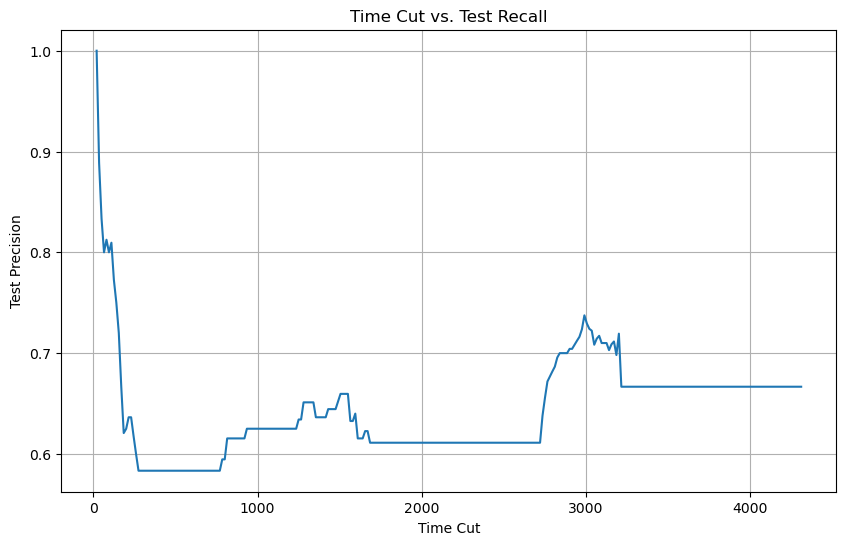

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting time_cut vs. test_accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x='metrics.time_cut', y='metrics.final_precision', data=df_charlie)
plt.title('Time Cut vs. Test Recall')
plt.xlabel('Time Cut')
plt.ylabel('Test Precision')
plt.grid(True)
plt.show()

In [33]:
# Get the experiment ID or name
import mlflow
import pandas as pd
df = pd.read_csv("posts_by_time_cut.csv")

experiment = mlflow.get_experiment(79)
print(experiment.name)

if experiment is not None:
    experiment_id = experiment.experiment_id

    # Retrieve all runs in the experiment as a DataFrame
    df_charlie = mlflow.search_runs(experiment_ids=[experiment_id]).dropna(subset='end_time')
    
    # Show the DataFrame
    #print(df)
else:
    print(f"Experiment '{experiment_name}' not found.")

GAT Network 2025-06-07 2 German Wings Crash TF


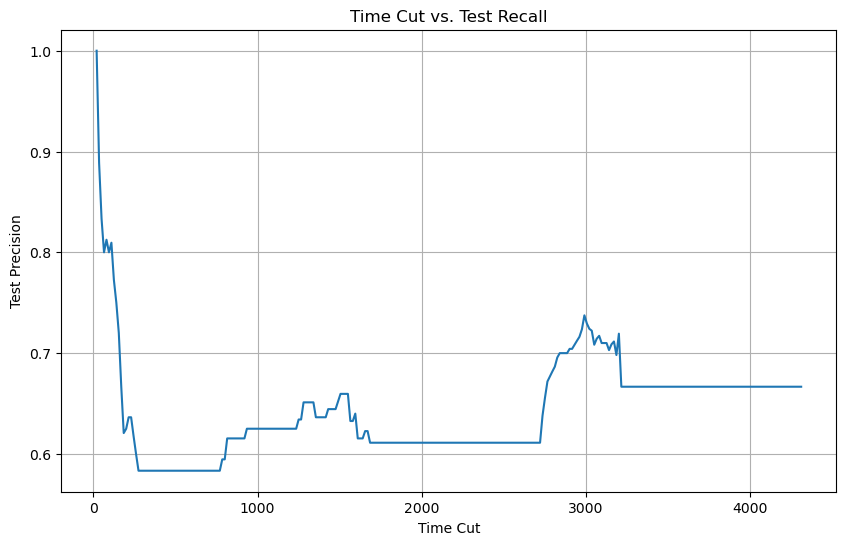

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting time_cut vs. test_accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x='metrics.time_cut', y='metrics.final_precision', data=df_charlie)
plt.title('Time Cut vs. Test Recall')
plt.xlabel('Time Cut')
plt.ylabel('Test Precision')
plt.grid(True)
plt.show()